# Code for the figures
This notebook contains scripts for producing figures in the paper and SI.

## Import required libraries 

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import math
import string
import pandas as pd
from scipy.stats import t 
from scipy.stats import norm
from statistics import mean
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from timeit import default_timer as timer
from functools import partial

## Global variables for plotting

In [37]:
DATA_FOLDER = 'data/'

SIZELINE = 0.8
AXWIDTH = 0.4
SUBLABEL_SIZE = 10
LABEL_SIZE = 6
FAMILY = 'Arial'
SINGLE_COLUMN = 8.5/2.54
ONE_FIVE_COLUMN = 11.4/2.54
DOUBLE_COLUMN = 17.4/2.54

mpl.rc('lines', linewidth=SIZELINE)
mpl.rc('axes', linewidth=AXWIDTH)
mpl.rc('font', size=LABEL_SIZE, family=FAMILY)
mpl.rc(('xtick.major', 'xtick.minor', 'ytick.major', 'ytick.minor'), width=AXWIDTH)

TRUE_MEAN_LABEL = 'True mean, $\mu_t$'
ESTD_MEAN_LABEL = 'Estimated\nmean, $\hat{\mu}$'
TRUE_STD_LABEL = 'True standard\ndeviation, $\sigma_t$'
ESTD_STD_LABEL = 'Estimated standard\ndeviation, $\hat{\sigma}$'
ENCOUNTER_LABEL = 'Target cell encounters'
POA_LABEL = 'Probability of activation'

DASH_STYLE = dict(color='k', linestyle='dashed', alpha=0.5)

## Frequently used functions

In [38]:
# update the mean and std
def update(initial_mean, initial_std, alpha, kappa, num_encounter, m_env, var_env):
    # constants in equtions for variance updating
    varc1 = (alpha-1)/(alpha-0.5)
    varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
    mean = [0]*num_encounter
    std = [0]*num_encounter
    mean[0] = initial_mean
    std[0] = initial_std
    for nstep in range(1, num_encounter):
        x = random.gauss(m_env, math.sqrt(var_env))  # gauss(mean,std)
        mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
        std[nstep] = math.sqrt(varc1*std[nstep-1]**2 +
                               varc2*(x-mean[nstep-1])**2)
    return(mean, std)

# Calculate the probability of activation
def POA(alpha, kappa, m, beta, u_target, var_target):
    theta = 0.01
    threshold = t.ppf(1-theta, 2*alpha, m,
                      math.sqrt((kappa+1)*beta/kappa/alpha))
    poa = 1-norm.cdf(threshold, loc=u_target, scale=math.sqrt(var_target))
    return(poa)

# Overview figure

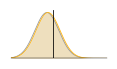

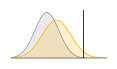

In [39]:
figw = SINGLE_COLUMN/2
figh = figw * 0.5
xmin = -2
xmax =  6
ymin =  0
ymax =  0.42

# Plotting -----------------------------------------------

fig = plt.figure(figsize=(figw, figh))

ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])

c_prior = '#969696'
mu_prior = 1
sigma_prior = 1
x_prior = np.arange(xmin, xmax, 0.01)
y_prior = np.exp(-(x_prior - mu_prior)**2 / (2 * sigma_prior**2)) / (sigma_prior * np.sqrt(2*np.pi))

ax.plot(x_prior, y_prior, c=c_prior)
ax.fill_between(x_prior, y_prior, color=c_prior, alpha=0.2, lw=0)

c_post = '#FFB511'
mu_post = 1.1
sigma_post = 1
x_post = np.arange(xmin, xmax, 0.01)
y_post = np.exp(-(x_post - mu_post)**2 / (2 * sigma_post**2)) / (sigma_post * np.sqrt(2*np.pi))

ax.plot(x_post, y_post, c=c_post)
ax.fill_between(x_post, y_post, color=c_post, alpha=0.2, lw=0)

ax.axvline(1.5, color='k')

plt.savefig('fig0-healthy.pdf', format='pdf', dpi=300, transparent=True)
plt.show()
plt.close()


# Plotting -----------------------------------------------

fig = plt.figure(figsize=(figw, figh))

ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])

c_prior = '#969696'
mu_prior = 1
sigma_prior = 1
x_prior = np.arange(xmin, xmax, 0.01)
y_prior = np.exp(-(x_prior - mu_prior)**2 / (2 * sigma_prior**2)) / (sigma_prior * np.sqrt(2*np.pi))

ax.plot(x_prior, y_prior, c=c_prior)
ax.fill_between(x_prior, y_prior, color=c_prior, alpha=0.2, lw=0)

c_post = '#FFB511'
mu_post = 1.8
sigma_post = 1.2
x_post = np.arange(xmin, xmax, 0.01)
y_post = np.exp(-(x_post - mu_post)**2 / (2 * sigma_post**2)) / (sigma_post * np.sqrt(2*np.pi))

ax.plot(x_post, y_post, c=c_post)
ax.fill_between(x_post, y_post, color=c_post, alpha=0.2, lw=0)

ax.axvline(4.0, color='k')

plt.savefig('fig0-unhealthy.pdf', format='pdf', dpi=300, transparent=True)
plt.show()
plt.close()

# Figure 1. Immune cells adapt to a static environment

## Part 1. Generation of data for the evolution of mean and standard deviation.

In [40]:
alpha = 10  
kappa = 20
m_env = 0
var_env = 4
num_encounter = 100

# Fig 1 Code 1/2
df = pd.DataFrame()

# part 1. initial different mean and same var ------------------------------------
initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)
for i_case in range(num_means):
    initial_mean = initial_means[i_case]
    df['mean%d' % i_case], df['std%d' % i_case] = update(initial_mean, initial_std, alpha, kappa, num_encounter,
                                                         m_env, var_env)

# part 2. initial same mean and different var ------------------------------------
initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)
for i_case in range(num_means, num_means+num_stds):
    initial_std = initial_stds[i_case-num_means]
    df['mean%d' % i_case], df['std%d' % i_case] = update(initial_mean, initial_std, alpha, kappa, num_encounter,
                                                         m_env, var_env)

df.to_csv('estimated_mean_std_alpha%d.csv.gz' %
          alpha, index=None, header=True, compression='gzip')
print('Fig 1 data done')

Fig 1 data done


## Part 2. Plotting

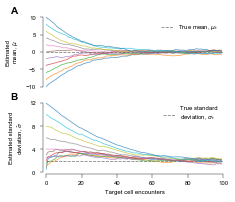

In [41]:
# Fig 1 Code 2/2 plottting

alpha = 10  # 5
kappa = 20  # 10
m_env = 0
var_env = 4
num_encounter = 100

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

# read data
data = pd.read_csv('%sestimated_mean_std_alpha%d.csv.gz' %
                   (DATA_FOLDER, 10), compression='gzip')

# Plotting -----------------------------------------------
# fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.85))
# plt.rc('font', size=LABEL_SIZE, family=FAMILY)
# ax1 = fig.add_axes([0.23, 0.57, 0.735, 0.36])
# ax2 = fig.add_axes([0.23, 0.125, 0.735, 0.36])

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))

ax1 = fig.add_axes([0.20, 0.57, 0.735, 0.36])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.set_xlim([0, num_encounter])
ax1.set_ylim([-10, 10])
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_ylabel(ESTD_MEAN_LABEL, fontsize=LABEL_SIZE)
ax1.text(-0.2, 1.05, string.ascii_uppercase[0],
         transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax1.axhline(0.0, label=TRUE_MEAN_LABEL, **DASH_STYLE)

ax2 = fig.add_axes([0.20, 0.125, 0.735, 0.36])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.set_xlim([0, num_encounter])
ax2.set_ylim([0, 12])
ax2.set_yticks([0, 4, 8, 12])
ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
ax2.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
ax2.text(-0.2, 1.05, string.ascii_uppercase[1],
         transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax2.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)

# Case 1 different means and same variance ---------------
for j_mu in range(num_means):
    ax1.plot(data['mean%d' % j_mu], alpha=0.7)

# Case 2 initial same mu and different var ---------------
for j_std in range(num_means, num_means+num_stds):
    ax2.plot(data['std%d' % j_std], alpha=0.7)

plt.savefig('fig1-adaptation-static.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# SI Figure 1

In [42]:
alphas = [5, 20]
kappas = [10, 40]
m_env = 0
var_env = 4
num_encounter = 200

for alpha, kappa in zip(alphas, kappas):

    # Fig 1 Code 1/2
    df = pd.DataFrame()

    # part 1. initial different mean and same var ------------------------------------
    initial_means = np.arange(-10, 11, 2)
    initial_std = 1
    num_means = len(initial_means)
    for i_case in range(num_means):
        initial_mean = initial_means[i_case]
        df['mean%d' % i_case], df['std%d' % i_case] = update(initial_mean, initial_std, alpha, kappa, num_encounter,
                                                             m_env, var_env)

    # part 2. initial same mean and different var ------------------------------------
    initial_mean = 5
    initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
    num_stds = len(initial_stds)
    for i_case in range(num_means, num_means+num_stds):
        initial_std = initial_stds[i_case-num_means]
        df['mean%d' % i_case], df['std%d' % i_case] = update(initial_mean, initial_std, alpha, kappa, num_encounter,
                                                             m_env, var_env)

    df.to_csv('estimated_mean_std_alpha%d.csv.gz' %
              alpha, index=None, header=True, compression='gzip')

print('Fig S1 data done')

Fig S1 data done


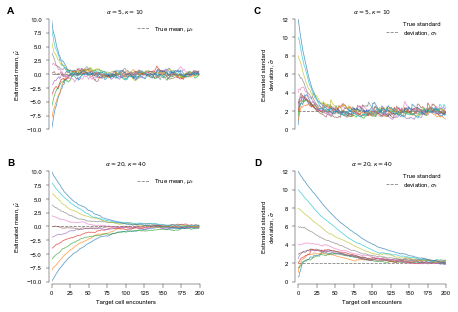

In [45]:
# SI Fig 1  different memory
# Compare alpha = 5 vs 20

alphas = [5, 20]
kappas = [10, 40]
m_env = 0
var_env = 4
num_encounter = 200

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

if __name__ == '__main__':
    fig = plt.figure(figsize=(DOUBLE_COLUMN, 4.5))
    plt.rc('font', size=LABEL_SIZE, family=FAMILY)
    ax1 = fig.add_axes([0.15, 0.59, 0.3, 0.34])
    ax2 = fig.add_axes([0.15, 0.12, 0.3, 0.34])
    ax3 = fig.add_axes([0.65, 0.59, 0.3, 0.34])
    ax4 = fig.add_axes([0.65, 0.12, 0.3, 0.34])
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.axes.get_xaxis().set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax1.spines['left'].set_position(('axes', -0.02))
    ax3.spines['left'].set_position(('axes', -0.02))
    ax2.spines['bottom'].set_position(('axes', -0.02))
    ax2.spines['left'].set_position(('axes', -0.02))
    ax4.spines['bottom'].set_position(('axes', -0.02))
    ax4.spines['left'].set_position(('axes', -0.02))
    ax1.set_xlim([0, num_encounter])
    ax1.set_ylim([-10, 10])
    ax2.set_xlim([0, num_encounter])
    ax2.set_ylim([-10, 10])
    ax3.set_xlim([0, num_encounter])
    ax3.set_ylim([0, 12])
    ax4.set_xlim([0, num_encounter])
    ax4.set_ylim([0, 12])

    ax1.axhline(m_env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_ylabel('Estimated mean, $\hat{\mu}$', fontsize=LABEL_SIZE)
    ax1.text(-0.3, 1.05, string.ascii_uppercase[0],
             transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax1.set_title(r'$\alpha=5, \kappa=10$', fontsize=LABEL_SIZE)

    ax2.axhline(m_env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
    ax2.legend(loc='upper right', frameon=False)
    ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
    ax2.set_ylabel('Estimated mean, $\hat{\mu}$', fontsize=LABEL_SIZE)
    ax2.text(-0.3, 1.05, string.ascii_uppercase[1],
             transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax2.set_title(r'$\alpha=20, \kappa=40$', fontsize=LABEL_SIZE)

    ax3.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
    ax3.legend(loc='upper right', frameon=False)
    ax3.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
    ax3.text(-0.3, 1.05, string.ascii_uppercase[2],
             transform=ax3.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax3.set_title(r'$\alpha=5, \kappa=10$', fontsize=LABEL_SIZE)

    ax4.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
    ax4.legend(loc='upper right', frameon=False)
    ax4.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
    ax4.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
    ax4.text(-0.3, 1.05, string.ascii_uppercase[3],
             transform=ax4.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax4.set_title(r'$\alpha=20, \kappa=40$', fontsize=LABEL_SIZE)

    # different initial mu and same var ------------------------------------
    data_shortmem = pd.read_csv(
        '%sestimated_mean_std_alpha%d.csv.gz' % (DATA_FOLDER, 5), compression='gzip')
    data_longmem = pd.read_csv(
        '%sestimated_mean_std_alpha%d.csv.gz' % (DATA_FOLDER, 20), compression='gzip')
    for j_mu in range(num_means):
        ax1.plot(data_shortmem['mean%d' % j_mu], alpha=0.7)
        ax2.plot(data_longmem['mean%d' % j_mu], alpha=0.7)

    for j_std in range(num_means, num_means+num_stds):
        ax3.plot(data_shortmem['std%d' % j_std], alpha=0.7)
        ax4.plot(data_longmem['std%d' % j_std], alpha=0.7)
    plt.savefig('figs1-adaptation-memory.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()

# Figure 2. Immune cells adapt to changing environments, mimicking experimentally observed development of hyposensitivity and recovery

## Part 1. Generation of data for evolution of estimated mean, standard deviation and probaility of activation.

In [44]:
# Fig 2 variables
alpha = 10
kappa = 20
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 100
num3env = 150
total_num = num1env+num2env+num3env

# Fig 2 code 1/2 data for 'Single NK cell adapt to new environment'
# mean std and probability of activation evolution
mean = [0]*total_num
std = [0]*total_num
poa = [0]*total_num
beta = [0]*total_num
mean[0] = m_env1
std[0] = math.sqrt(var_env1)
beta[0] = std[0]**2*(alpha-1)
poa[0] = (POA(alpha, kappa, mean[0], beta[0], m_env2, var_env2))

# healthy environment
for nstep in range(1, num1env):
    x = random.gauss(m_env1, math.sqrt(var_env1))  # gauss(mean,std)
    mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
    std[nstep] = math.sqrt(varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2)
    beta[nstep] = std[nstep-1]**2*(alpha-1)
    poa[nstep] = POA(alpha, kappa, mean[nstep-1],
                     beta[nstep], m_env2, var_env2)
# unhealthy environment
for nstep in range(num1env, num1env+num2env):
    x = random.gauss(m_env2, math.sqrt(var_env2))  # gauss(mean,std)
    mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
    std[nstep] = math.sqrt(varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2)
    beta[nstep] = std[nstep-1]**2*(alpha-1)
    poa[nstep] = POA(alpha, kappa, mean[nstep-1],
                     beta[nstep], m_env2, var_env2)
# healthy environment
for nstep in range(num1env+num2env, num1env+num2env+num3env):
    x = random.gauss(m_env1, math.sqrt(var_env1))  # gauss(mean,std)
    mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
    std[nstep] = math.sqrt(varc1*std[nstep-1]**2+varc2*(x-mean[nstep-1])**2)
    beta[nstep] = std[nstep-1]**2*(alpha-1)
    poa[nstep] = POA(alpha, kappa, mean[nstep-1],
                     beta[nstep], m_env2, var_env2)

# data saving ----------------------------------------------------
df = pd.DataFrame()
df['mean'] = mean
df['std'] = std
df['beta'] = beta
df['poa'] = poa
df.to_csv('MultiEnvs_mean_std_beta_poa.csv.gz',
          index=None, header=True, compression='gzip')
print('Fig 2 data done')

Fig 2 data done


## Part 2. Plotting

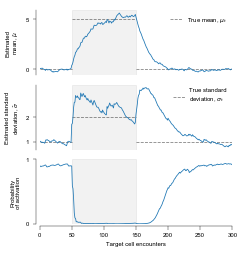

In [46]:
# Fig 2. 2/2

alpha = 10
kappa = 20
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 100
num3env = 150
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv('%sMultiEnvs_mean_std_beta_poa.csv.gz' %
                   (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.0))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.165, 0.73, 0.8, 0.27])
ax2 = fig.add_axes([0.165, 0.42, 0.8, 0.27])
ax3 = fig.add_axes([0.165, 0.11, 0.8, 0.27])
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax1.set_xlim(0, total_num)
ax2.set_xlim(0, total_num)
ax3.set_xlim(0, total_num)
ax1.set_yticks([0, 5])
ax1.set_yticklabels([0, 5])
ax2.set_yticks([1, 2])
ax2.set_yticklabels([1, 2])
ax3.set_yticks([0, 1])
ax1.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')
ax2.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')
ax3.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')

ax1.hlines(y=m_env1, xmin=0, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(y=m_env2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(y=m_env1, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

ax2.hlines(y=math.sqrt(var_env1), xmin=0, xmax=num1env,
           label=TRUE_STD_LABEL, **DASH_STYLE)
ax2.hlines(y=math.sqrt(var_env2), xmin=num1env,
           xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=math.sqrt(var_env1), xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

#ax3.hlines(0.99, 0, num1env, **DASH_STYLE)
#ax3.hlines(0, num1env, num1env+num2env, **DASH_STYLE)
#ax3.hlines(0.99, num1env+num2env,num1env+num2env+num3env, **DASH_STYLE)

ax3.set_ylim(-0.01, 1)
#ax3.set_yticks(np.arange(0, 1.1, step=1))

# plot
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)
ax1.plot(data['mean'])
ax1.set_ylabel(ESTD_MEAN_LABEL)
ax2.plot(data['std'])
ax2.set_ylabel(ESTD_STD_LABEL)
ax3.plot(data['poa'])
ax3.set_xlabel(ENCOUNTER_LABEL)
ax3.set_ylabel('Probability\nof activation')
plt.savefig('fig2-adaptation-dynamic.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure 3. Finite memory of past interactions with target cells results in heterogeneous immune cell behaviors

## Part 1.  Generation of data for evolution of estimated mean, standard deviation and probaility of activation

In [47]:
# Fig3 global variables
#global variable
num_cell = 500
alpha = 10
kappa = 20
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 100
num3env = 150
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
total_num = num1env+num2env+num3env

# Fig 3 1/2 data for Finite memory of past interactions with
# target cells results in heterogeneous immune cell behaviors.
mean = [0]*total_num
std = [0]*total_num
poa = [0]*total_num
beta = [0]*total_num
mean[0] = m_env1
std[0] = math.sqrt(var_env1)
beta[0] = std[0]**2*(alpha-1)
poa[0] = (POA(alpha, kappa, mean[0], beta[0], m_env2, var_env2))
df = pd.DataFrame()

# loop over num_cell
for i_cell in range(num_cell):
    mean[0] = m_env1
    std[0] = math.sqrt(var_env1)
    beta[0] = std[0]**2*(alpha-1)
    poa[0] = (POA(alpha, kappa, mean[0], beta[0], m_env2, var_env2))
    # healthy environment
    for nstep in range(1, num1env):
        x = random.gauss(m_env1, math.sqrt(var_env1))  # gauss(mean,std)
        mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
        std[nstep] = math.sqrt(varc1*std[nstep-1]**2 +
                               varc2*(x-mean[nstep-1])**2)
        beta[nstep] = std[nstep-1]**2*(alpha-1)
        poa[nstep] = POA(alpha, kappa, mean[nstep-1],
                         beta[nstep], m_env2, var_env2)
    # unhealthy environment
    for nstep in range(num1env, num1env+num2env):
        x = random.gauss(m_env2, math.sqrt(var_env2))  # gauss(mean,std)
        mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
        std[nstep] = math.sqrt(varc1*std[nstep-1]**2 +
                               varc2*(x-mean[nstep-1])**2)
        beta[nstep] = std[nstep-1]**2*(alpha-1)
        poa[nstep] = POA(alpha, kappa, mean[nstep-1],
                         beta[nstep], m_env2, var_env2)
    # healthy environment
    for nstep in range(num1env+num2env, num1env+num2env+num3env):
        x = random.gauss(m_env1, math.sqrt(var_env1))  # gauss(mean,std)
        mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
        std[nstep] = math.sqrt(varc1*std[nstep-1]**2 +
                               varc2*(x-mean[nstep-1])**2)
        beta[nstep] = std[nstep-1]**2*(alpha-1)
        poa[nstep] = POA(alpha, kappa, mean[nstep-1],
                         beta[nstep], m_env2, var_env2)
    # data saving ----------------------------------------------------
    df['mean%d' % i_cell] = mean
    df['std%d' % i_cell] = std
    df['beta%d' % i_cell] = beta
    df['poa%d' % i_cell] = poa

df.to_csv('MultiEnvs_MultiCells_mean_std_beta_poa.csv.gz',
          index=None, header=True, compression='gzip')
print('Fig 3 data done')

Fig 3 data done


## Part 2. Plotting

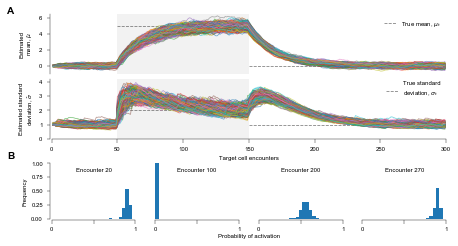

In [48]:
# Fig3 2/2

num_cell = 500
alpha = 10
kappa = 20
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 100
num3env = 150
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv(
    '%sMultiEnvs_MultiCells_mean_std_beta_poa.csv.gz' % (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(DOUBLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
fig.text(
    0.05, 0.95, string.ascii_uppercase[0], size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.05, 0.35, string.ascii_uppercase[1], size=SUBLABEL_SIZE, weight='bold')

ax1 = fig.add_axes([0.14, 0.7, 0.8, 0.25])
ax2 = fig.add_axes([0.14, 0.43, 0.8, 0.25])
ax3 = fig.add_axes([0.14, 0.1, 0.17, 0.23])
ax4 = fig.add_axes([0.35, 0.1, 0.17, 0.23])
ax5 = fig.add_axes([0.56, 0.1, 0.17, 0.23])
ax6 = fig.add_axes([0.77, 0.1, 0.17, 0.23])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.005))
ax1.spines['bottom'].set_position(('axes', -0.005))
ax2.spines['left'].set_position(('axes', -0.005))
ax2.spines['bottom'].set_position(('axes', -0.005))
ax1.set_ylim(-1, 6.5)
ax2.set_ylim(0, 4.2)
ax1.set_xlim(0, 300)
ax2.set_xlim(0, 300)
ax1.set_xticks([])

ax1.axvspan(50, 150, alpha=0.1, color='grey', lw=0)
ax2.axvspan(50, 150, alpha=0.1, color='grey', lw=0)
ax1.hlines(0, xmin=-10, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(5, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(0, xmin=num1env+num2env, xmax=num1env+num2env+num3env, **DASH_STYLE)
ax2.hlines(y=1, xmin=-10, xmax=num1env, label=TRUE_STD_LABEL, **DASH_STYLE)
ax2.hlines(y=2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=1, xmin=num1env+num2env, xmax=num1env +
           num2env+num3env, **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)

for i_cell in range(num_cell):
    ax1.plot(data['mean%d' % i_cell], alpha=0.6)
ax1.set_ylabel(ESTD_MEAN_LABEL)

for i_cell in range(num_cell):
    ax2.plot(data['std%d' % i_cell], alpha=0.6)
ax2.set_ylabel(ESTD_STD_LABEL)

ax2.set_xlabel(ENCOUNTER_LABEL)

#ax3.set_ylabel('Probability of activation (%)')
ax3.set_xticks(np.arange(0, 1.01, step=0.5))
ax4.set_xticks(np.arange(0, 1.01, step=0.5))
ax5.set_xticks(np.arange(0, 1.01, step=0.5))
ax6.set_xticks(np.arange(0, 1.01, step=0.5))
ax3.set_xticklabels(['0', '', '1'])
ax4.set_xticklabels(['0', '', '1'])
ax5.set_xticklabels(['0', '', '1'])
ax6.set_xticklabels(['0', '', '1'])
ax3.set_ylim([0, 1])
ax4.set_ylim([0, 1])
ax5.set_ylim([0, 1])
ax6.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax4.set_xlim([0, 1])
ax5.set_xlim([0, 1])
ax6.set_xlim([0, 1])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax4.spines['bottom'].set_position(('axes', -0.02))
ax5.spines['bottom'].set_position(('axes', -0.02))
ax6.spines['bottom'].set_position(('axes', -0.02))

ax3.set_ylabel('Frequency')
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])

binstep = 0.04
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)

xbins = []
for ibin in range(int(1.0/binstep)):
    xbins.append(binstep*ibin)

# -----------------------------
poa_cols = [col for col in data.columns if 'poa' in col]

step_vals = [20, 100, 200, 270]
axes = [ax3, ax4, ax5, ax6]

for nstep, ax in zip(step_vals, axes):
    pointpoas = data.loc[nstep, poa_cols]
    statist = np.histogram(pointpoas, bins)[0]/num_cell
    ax.bar(xbins, height=statist, width=binstep, align='edge')
    ax.text(0.5, 0.85, 'Encounter %d' %
            nstep, ha='center', fontsize=LABEL_SIZE, color='k')

# ----------------------
fig.text(0.54, 0.02, POA_LABEL, ha='center')
plt.savefig('fig3-adaptation-dynamic-population.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure 4. Steady state distribution of immune cell adaptation and responsiveness due to finite memory

## Part 1. Solve the Fokker Planck Equation (See FKE.py which generates 'Fokker_planck_solution.csv.gz')

## Part 2. Calculate the probability of activation

In [49]:
# Fig 4 variables
u2 = 2  # data mean
sigma2 = 1  # data std
theta = 0.01
alpha = 10
kappa = 20
c1 = (alpha-1)/(alpha-0.5)
# constant in betanew = c1*beta + c2*(x-mu)**2
c2 = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1)

# Fig 4 2/3 Steady state distribution of immune cell adaptation and responsiveness due to finite memory.
# part 2 For each set of (\mu,\beta) calculate the probability of activation.
alpha = 10
kappa = 20

# antigen N(4.5,1)
mean_antigen = 4.5  # this value is where POA of the center
var_antigen = 1

# grid
NX = 101
NY = 1001
xmax = 2.5
xmin = 1.5
ymax = 15
ymin = 5
dx = (xmax-xmin)/(NX-1)
dy = (ymax-ymin)/(NY-1)

poa = [0]*(NX*NY)
for i in range(NX):
    for j in range(NY):
        mu = xmin+i*dx
        beta = ymin+j*dy
        poa[i*NY+j] = POA(alpha, kappa, mu, beta, mean_antigen, var_antigen)
df = pd.DataFrame()
df['poa'] = poa
df.to_csv('poa_matrix.csv.gz', index=None, header=True, compression='gzip')
print('Fig 4 poa matrix done')

Fig 4 poa matrix done


## Part 3. Plotting

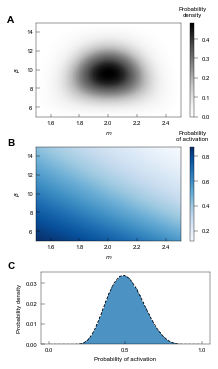

In [50]:
# Fig 4 3/3
# grid
NX = 101
NY = 1001
xmax = 2.5
xmin = 1.5
ymax = 15
ymin = 5
dx = (xmax-xmin)/(NX-1)
dy = (ymax-ymin)/(NY-1)

# load data
dataw = pd.read_csv('%sFokker_planck_solution.csv.gz' %
                    (DATA_FOLDER), compression='gzip')
col = dataw.columns[-1]
w = dataw[col]
w = np.array(w).reshape((NX, NY))
data = pd.read_csv('%spoa_matrix.csv.gz' % (DATA_FOLDER), compression='gzip')
poa = np.array(data['poa']).reshape((NX, NY))

# plotting ---------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.5))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.15, 0.69, 0.75, 0.26])
ax2 = fig.add_axes([0.15, 0.347, 0.75, 0.26])
ax3 = fig.add_axes([0.17, 0.06, 0.7, 0.2])
fig.text(
    0.03, 0.95, string.ascii_uppercase[0], size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.61, string.ascii_uppercase[1], size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.27, string.ascii_uppercase[2], size=SUBLABEL_SIZE, weight='bold')
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')
ax3.tick_params(direction='in')

ax1.set_xlabel(r'$m$')
ax1.set_ylabel(r'$\beta$')
ax2.set_xlabel(r'$m$')
ax2.set_ylabel(r'$\beta$')

ax3.set_xlabel(POA_LABEL)
ax3.set_ylabel('Probability density')
X = xmin+dx*np.arange(NX)
Y = ymin+dy*np.arange(NY)

colorinterpolation = 50  # Set colour interpolation and colour map
# .T means transpose because contourf treat T[i,j] as X[j] Y[i]
#pos1  = ax1.contourf(X, Y, w.T, colorinterpolation, cmap=plt.cm.get_cmap('Greys'))
pos1 = ax1.pcolormesh(X, Y, w.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Greys'))
cbar1 = fig.colorbar(pos1, ax=ax1)
cbar1.ax.set_title('Probability\ndensity', fontsize=LABEL_SIZE)
cbar1.set_ticks(np.arange(0, 0.9, step=0.1))

#pos2  = ax2.contourf(X, Y, poa.T, colorinterpolation, cmap=plt.cm.get_cmap('Blues'))
pos2 = ax2.pcolormesh(X, Y, poa.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Blues'))
cbar2 = fig.colorbar(pos2, ax=ax2)
cbar2.ax.set_title('Probability\nof activation', fontsize=LABEL_SIZE)
cbar2.set_ticks(np.arange(0, 1, step=0.2))

# bins for poa histgram
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)
xbin = []
y3 = []
for ibin in range(int(1.0/binstep)):
    xbin.append((ibin+0.5)*binstep)
    y3.append(0)
for ix in range(NX):
    for iy in range(NY):
        ibin = 0
        while ibin*binstep < poa[ix, iy]:
            ibin += 1
        y3[ibin] += w[ix, iy]
y3plot = [float(i)/sum(y3) for i in y3]
ax3.plot(xbin, y3plot, color='black', linestyle='dashed')
ax3.bar(xbin, height=y3plot, width=binstep, align='center', alpha=0.8)
ax3.set_xticks(np.arange(0, 1.01, step=0.5))

plt.savefig('fig4-heterogeneity.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure 5. Immune cells responses are diverse, but follow predictable trends de- pending on the level of stimulation received from target cells. 

## Part 1. Evolution of (mu, beta) in different memory

In [51]:
def update_mubeta(initial_mean, initial_beta, alpha, kappa, num_encounter, m_env, var_env):
    c1 = (alpha-1)/(alpha-0.5)
    # constant in betanew = c1*beta + c2*(x-mu)**2
    c2 = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1)
    mean_old = initial_mean
    beta_old = initial_beta
    for nstep in range(1, num_encounter):
        x = random.gauss(m_env, math.sqrt(var_env))  # gauss(mean,std)
        mean_new = (kappa*mean_old+x)/(kappa+1)
        beta_new = c1*beta_old+c2*(x-mean_old)**2
        mean_old, beta_old = mean_new, beta_new
    return(mean_new, beta_new)


# Fig 5 global variables
num_cells = 100000
num_encounter = 1000
m_env = 2
var_env = 1
df = pd.DataFrame()

# initial distribution form and number of NK cells
init_mu = [0]*num_cells
init_beta = [0]*num_cells
for i in range(num_cells):
    init_mu[i] = random.random()*5  # [0,5)
    init_beta[i] = random.random()*40  # [0,40)

# loop to get mu beta distribution after num_encounter steps
for alpha in [5, 10, 20, 50]:
    print(alpha)
    kappa = 2*alpha
    mu = [0]*num_cells
    beta = [0]*num_cells
    for i_cell in range(num_cells):
        mu[i_cell], beta[i_cell] = update_mubeta(init_mu[i_cell], init_beta[i_cell], alpha, kappa,
                                                 num_encounter, m_env, var_env)
    df['alpha_%d_mu' % (alpha)] = mu
    df['alpha_%d_beta' % (alpha)] = beta
df.to_csv('diff_memory_population.csv.gz',
          index=None, header=True, compression='gzip')
print('update mu beta done')

5
10
20
50
update mu beta done


## Part 2. Simulate the probability of activation distribution for different memory against different target distribution.

In [52]:
# 5.1 different memory length, NK cell response are heterogeneous
var2 = 1

# grid
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)

data = pd.read_csv('diff_memory_population.csv.gz', compression='gzip')
df = pd.DataFrame()
for u2 in [6, 5, 4, 3]:
    for mem_alpha in [5, 10, 20, 50]:
        print(u2, mem_alpha)
        kappa = 2*mem_alpha
        mu = data['alpha_%d_mu' % (mem_alpha)]
        beta = data['alpha_%d_beta' % (mem_alpha)]
        poa = [0]*len(mu)
        for imu in range(len(mu)):
            poa[imu] = POA(mem_alpha, kappa, mu[imu], beta[imu], u2, var2)
        df['target_mean_%d_alpha_%d' %
            (u2, mem_alpha)] = np.histogram(poa, bins)[0]
df.to_csv('histogram_poa.csv.gz', index=None, header=True, compression='gzip')
print('Figure 5 poa histogram done')

6 5
6 10
6 20
6 50
5 5
5 10
5 20
5 50
4 5
4 10
4 20
4 50
3 5
3 10
3 20
3 50
Figure 5 poa histogram done


## Part 3. Plotting

step1
step2
step3
step4


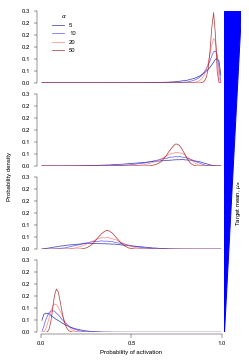

In [54]:
# Fig 5 1/2 different memory length, NK cell response are heterogeneous
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
data = pd.read_csv('%shistogram_poa.csv.gz' % (DATA_FOLDER))
num_cells = 100000

# grid
x = []
binstep = 0.01
for ibin in range(int(1.0/binstep)):
    x.append((ibin+0.5)*binstep)

# figure
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.5))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
fig.text(0.01, 0.5, 'Probability density', rotation='vertical',
         ha='center', va='center', fontsize=LABEL_SIZE)

ax0 = fig.add_axes([0.90, 0.07, 0.07, 0.89])
ax1 = fig.add_axes([0.14, 0.76, 0.75, 0.20])
ax2 = fig.add_axes([0.14, 0.53, 0.75, 0.20])
ax3 = fig.add_axes([0.14, 0.30, 0.75, 0.20])
ax4 = fig.add_axes([0.14, 0.07, 0.75, 0.20])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax4.spines['left'].set_position(('axes', -0.02))
ax4.spines['bottom'].set_position(('axes', -0.02))


ax1.set_xlim([0, 1])
ax2.set_xlim([0, 1])
ax3.set_xlim([0, 1])
ax4.set_xlim([0, 1])
ax1.set_ylim([0, 0.3])
ax2.set_ylim([0, 0.3])
ax3.set_ylim([0, 0.3])
ax4.set_ylim([0, 0.3])

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks(np.arange(0, 1.01, step=0.5))
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)
ax3.tick_params(top=False, labelbottom=False)

ax4.set_xlabel(POA_LABEL)

ax0.text(0.8, 0.4, r'Target mean, $\mu_{a}$', ha='center', va='center', rotation='vertical',
         transform=ax0.transAxes, fontsize=LABEL_SIZE)
triangle = ([(0, 0), (0, 1), (1, 1)])
trip = mpl.patches.Polygon(triangle, closed=True, color='blue')
ax0.add_patch(trip)
ax0.axis('off')

print('step1')
u2 = 6
cmap = plt.get_cmap('seismic')
dicmap = {5: 0.1, 10: 0.3, 20: 0.65, 50: 0.95}
for mem_alpha in [5, 10, 20, 50]:
    y = data['target_mean_%d_alpha_%d' % (u2, mem_alpha)]/num_cells
    ax1.plot(x, y, label='%d' % mem_alpha,
             c=cmap(dicmap[mem_alpha]), alpha=0.7)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.legend(title=r'$\alpha$', bbox_to_anchor=(
    0.05, 1), loc=2, borderaxespad=0, frameon=False)

print('step2')
u2 = 5
for mem_alpha in [5, 10, 20, 50]:
    y = data['target_mean_%d_alpha_%d' % (u2, mem_alpha)]/num_cells
    ax2.plot(x, y, c=cmap(dicmap[mem_alpha]), alpha=0.7)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

print('step3')
u2 = 4
for mem_alpha in [5, 10, 20, 50]:
    y = data['target_mean_%d_alpha_%d' % (u2, mem_alpha)]/num_cells
    ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax3.plot(x, y, c=cmap(dicmap[mem_alpha]), alpha=0.7)

print('step4')
u2 = 3
for mem_alpha in [5, 10, 20, 50]:
    y = data['target_mean_%d_alpha_%d' % (u2, mem_alpha)]/num_cells
    ax4.plot(x, y, c=cmap(dicmap[mem_alpha]), alpha=0.7)
    ax4.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig('fig5-heterogeneity-response.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Signal modified by Sigmoid function

In [8]:
# use modified signal to update the mean and variance
def update2(initial_mean, initial_std, alpha, kappa, num_encounter, m_env, var_env):
	# constants in equtions for variance updating
	varc1 = (alpha-1)/(alpha-0.5)
	varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
	mean = [0]*num_encounter
	std = [0]*num_encounter
	mean[0] = initial_mean
	std[0] = initial_std
	for nstep in range(1, num_encounter):
		x = random.gauss(m_env, math.sqrt(var_env))  # gauss(mean,std)
		x = mean[nstep-1]+(2/(1 + math.exp(-( x- mean[nstep-1]))) -1)*2
		mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
		std[nstep] = math.sqrt(varc1*std[nstep-1]**2 +
							   varc2*(x-mean[nstep-1])**2)
	return(mean, std)

# Si Figure 3

In [11]:
alpha = 10  
kappa = 20
m_env = 0
var_env = 4
num_encounter = 200

# Fig 1 Code 1/2
df = pd.DataFrame()

# part 1. initial different mean and same var ------------------------------------
initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)
for i_case in range(num_means):
    initial_mean = initial_means[i_case]
    df['mean%d' % i_case], df['std%d' % i_case] = update2(initial_mean, initial_std, alpha, kappa, num_encounter,
                                                         m_env, var_env)

# part 2. initial same mean and different var ------------------------------------
initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)
for i_case in range(num_means, num_means+num_stds):
    initial_std = initial_stds[i_case-num_means]
    df['mean%d' % i_case], df['std%d' % i_case] = update2(initial_mean, initial_std, alpha, kappa, num_encounter,
                                                         m_env, var_env)

df.to_csv('SI3_estimated_mean_std_alpha%d.csv.gz' %
          alpha, index=None, header=True, compression='gzip')
print('Fig SI 3 data done')

Fig SI 3 data done


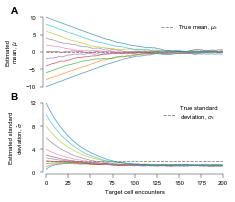

In [14]:
# Fig 1 Code 2/2 plottting

alpha = 10  # 5
kappa = 20  # 10
m_env = 0
var_env = 4
num_encounter = 200

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

# read data
data = pd.read_csv('%sSI3_estimated_mean_std_alpha%d.csv.gz' %
                   (DATA_FOLDER, 10), compression='gzip')

# Plotting -----------------------------------------------
# fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.85))
# plt.rc('font', size=LABEL_SIZE, family=FAMILY)
# ax1 = fig.add_axes([0.23, 0.57, 0.735, 0.36])
# ax2 = fig.add_axes([0.23, 0.125, 0.735, 0.36])

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))

ax1 = fig.add_axes([0.20, 0.57, 0.735, 0.36])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.set_xlim([0, num_encounter])
ax1.set_ylim([-10, 10])
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_ylabel(ESTD_MEAN_LABEL, fontsize=LABEL_SIZE)
ax1.text(-0.2, 1.05, string.ascii_uppercase[0],
         transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax1.axhline(0.0, label=TRUE_MEAN_LABEL, **DASH_STYLE)

ax2 = fig.add_axes([0.20, 0.125, 0.735, 0.36])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.set_xlim([0, num_encounter])
ax2.set_ylim([0, 12])
ax2.set_yticks([0, 4, 8, 12])
ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
ax2.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
ax2.text(-0.2, 1.05, string.ascii_uppercase[1],
         transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax2.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)

# Case 1 different means and same variance ---------------
for j_mu in range(num_means):
    ax1.plot(data['mean%d' % j_mu], alpha=0.7)

# Case 2 initial same mu and different var ---------------
for j_std in range(num_means, num_means+num_stds):
    ax2.plot(data['std%d' % j_std], alpha=0.7)

plt.savefig('figSI3-adaptation-static.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# SI Figure 4

In [21]:
# Fig 2 variables
alpha = 10
kappa = 20
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 150
num3env = 150
total_num = num1env+num2env+num3env

# Fig 2 code 1/2 data for 'Single NK cell adapt to new environment'
# mean std and probability of activation evolution
mean = [0]*total_num
std = [0]*total_num
poa = [0]*total_num
beta = [0]*total_num
mean[0] = m_env1
std[0] = math.sqrt(var_env1)
beta[0] = std[0]**2*(alpha-1)
poa[0] = (POA(alpha, kappa, mean[0], beta[0], m_env2, var_env2))

# healthy environment
mean,std =update2(m_env1, math.sqrt(var_env1), alpha, kappa, num1env, m_env1, var_env1)

# unhealthy environment
mean+=update2(mean[-1], std[-1], alpha, kappa, num2env, m_env2, var_env2)[0]
std +=update2(mean[-1], std[-1], alpha, kappa, num2env, m_env2, var_env2)[1]

# healthy environment
mean+=update2(mean[-1], std[-1], alpha, kappa, num3env, m_env1, var_env1)[0]
std +=update2(mean[-1], std[-1], alpha, kappa, num3env, m_env1, var_env1)[1]

# calculate the poa
for nstep in range(num1env+num2env+num3env):
    beta[nstep] = std[nstep-1]**2*(alpha-1)
    poa[nstep] = POA(alpha, kappa, mean[nstep-1],
                     beta[nstep], m_env2, var_env2)

# data saving ----------------------------------------------------
df = pd.DataFrame()
df['mean'] = mean
df['std'] = std
df['beta'] = beta
df['poa'] = poa
df.to_csv('SI4_MultiEnvs_mean_std_beta_poa.csv.gz',
          index=None, header=True, compression='gzip')
print('Fig SI 4 data done')

Fig SI 4 data done


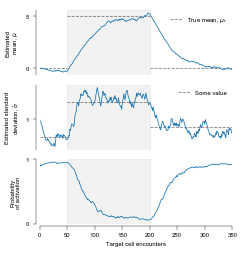

In [35]:
# Fig 2. 2/2

alpha = 10
kappa = 20
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 150
num3env = 150
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv('%sSI4_MultiEnvs_mean_std_beta_poa.csv.gz' %
                   (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.0))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.165, 0.73, 0.8, 0.27])
ax2 = fig.add_axes([0.165, 0.42, 0.8, 0.27])
ax3 = fig.add_axes([0.165, 0.11, 0.8, 0.27])
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax1.set_xlim(0, total_num)
ax2.set_xlim(0, total_num)
ax3.set_xlim(0, total_num)
ax1.set_yticks([0, 5])
ax1.set_yticklabels([0, 5])
ax2.set_yticks([1, 2])
ax2.set_yticklabels([1, 2])
ax3.set_yticks([0, 1])
ax1.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')
ax2.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')
ax3.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')

ax1.hlines(y=m_env1, xmin=0, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(y=m_env2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(y=m_env1, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)
y1=np.mean(np.array(data['std'][0:num1env]))
y2=np.mean(np.array(data['std'][num1env:num1env+num2env]))
y3=np.mean(np.array(data['std'][num1env+num2env:num1env+num2env+num3env]))
ax2.hlines(y=y1, xmin=0, xmax=num1env,
           label='Some value', **DASH_STYLE)
ax2.hlines(y=y2, xmin=num1env,
           xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=y3, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

#ax3.hlines(0.99, 0, num1env, **DASH_STYLE)
#ax3.hlines(0, num1env, num1env+num2env, **DASH_STYLE)
#ax3.hlines(0.99, num1env+num2env,num1env+num2env+num3env, **DASH_STYLE)

ax3.set_ylim(-0.01, 1)
#ax3.set_yticks(np.arange(0, 1.1, step=1))

# plot
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)
ax1.plot(data['mean'])
ax1.set_ylabel(ESTD_MEAN_LABEL)
ax2.plot(data['std'])
ax2.set_ylabel(ESTD_STD_LABEL)
ax3.plot(data['poa'])
ax3.set_xlabel(ENCOUNTER_LABEL)
ax3.set_ylabel('Probability\nof activation')
plt.savefig('figSI4-adaptation-dynamic.pdf', format='pdf', dpi=300)
plt.show()
plt.close()